In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

/home/muttaqien-m/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/muttaqien-m/anaconda3/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
plt.style.use('ggplot')

## Build LeNet

In [3]:
# Define the LeNet-3 architecture for A, B, C classification
class LeNet3(nn.Module):
    def __init__(self):
        super(LeNet3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, 3)  # Output for A, B, C

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [4]:
# Define transformations and create dataset
transform = transforms.Compose([transforms.Grayscale(), # Convert to grayscale
                                transforms.Resize((32, 32)), # Resize to LeNet input size
                                transforms.RandomRotation(10), # Randomly rotate the image up to 10 degrees
                                transforms.ToTensor()])

train_dataset = ImageFolder(root="./letter/train", transform=transform)
test_dataset = ImageFolder(root="./letter/test", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Train Model

In [5]:
# Initialize the model, loss function, and optimizer
model = LeNet3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop with accuracy tracking
num_epochs = 200
accuracies = []

for epoch in range(num_epochs):
    model.train()
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    accuracies.append(accuracy)


    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

# Test the model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on test set: {accuracy * 100:.2f}%")

Epoch 1/200, Loss: 1.110278844833374
Epoch 2/200, Loss: 1.1032742261886597
Epoch 3/200, Loss: 1.0976126194000244
Epoch 4/200, Loss: 1.0903801918029785
Epoch 5/200, Loss: 1.086578369140625
Epoch 6/200, Loss: 1.0834190845489502
Epoch 7/200, Loss: 1.0806294679641724
Epoch 8/200, Loss: 1.0796868801116943
Epoch 9/200, Loss: 1.0854517221450806
Epoch 10/200, Loss: 1.0822821855545044
Epoch 11/200, Loss: 1.037926435470581
Epoch 12/200, Loss: 1.0499002933502197
Epoch 13/200, Loss: 0.9836031794548035
Epoch 14/200, Loss: 0.9587353467941284
Epoch 15/200, Loss: 0.8491150140762329
Epoch 16/200, Loss: 0.9479997158050537
Epoch 17/200, Loss: 0.846484899520874
Epoch 18/200, Loss: 0.7912052273750305
Epoch 19/200, Loss: 0.951080858707428
Epoch 20/200, Loss: 0.7199576497077942
Epoch 21/200, Loss: 0.8579834699630737
Epoch 22/200, Loss: 0.6622267961502075
Epoch 23/200, Loss: 0.75010746717453
Epoch 24/200, Loss: 0.8200108408927917
Epoch 25/200, Loss: 0.49356916546821594
Epoch 26/200, Loss: 0.5773192644119263
E

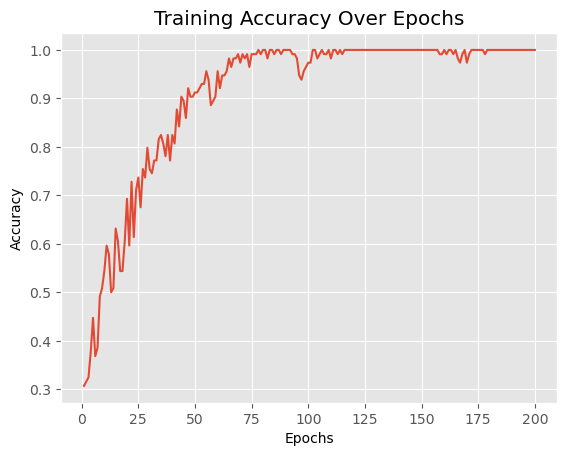

In [7]:
# Plotting the accuracy over epochs
plt.plot(range(1, num_epochs + 1), accuracies)
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Test Model

/tmp/ipykernel_107441/164636133.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')


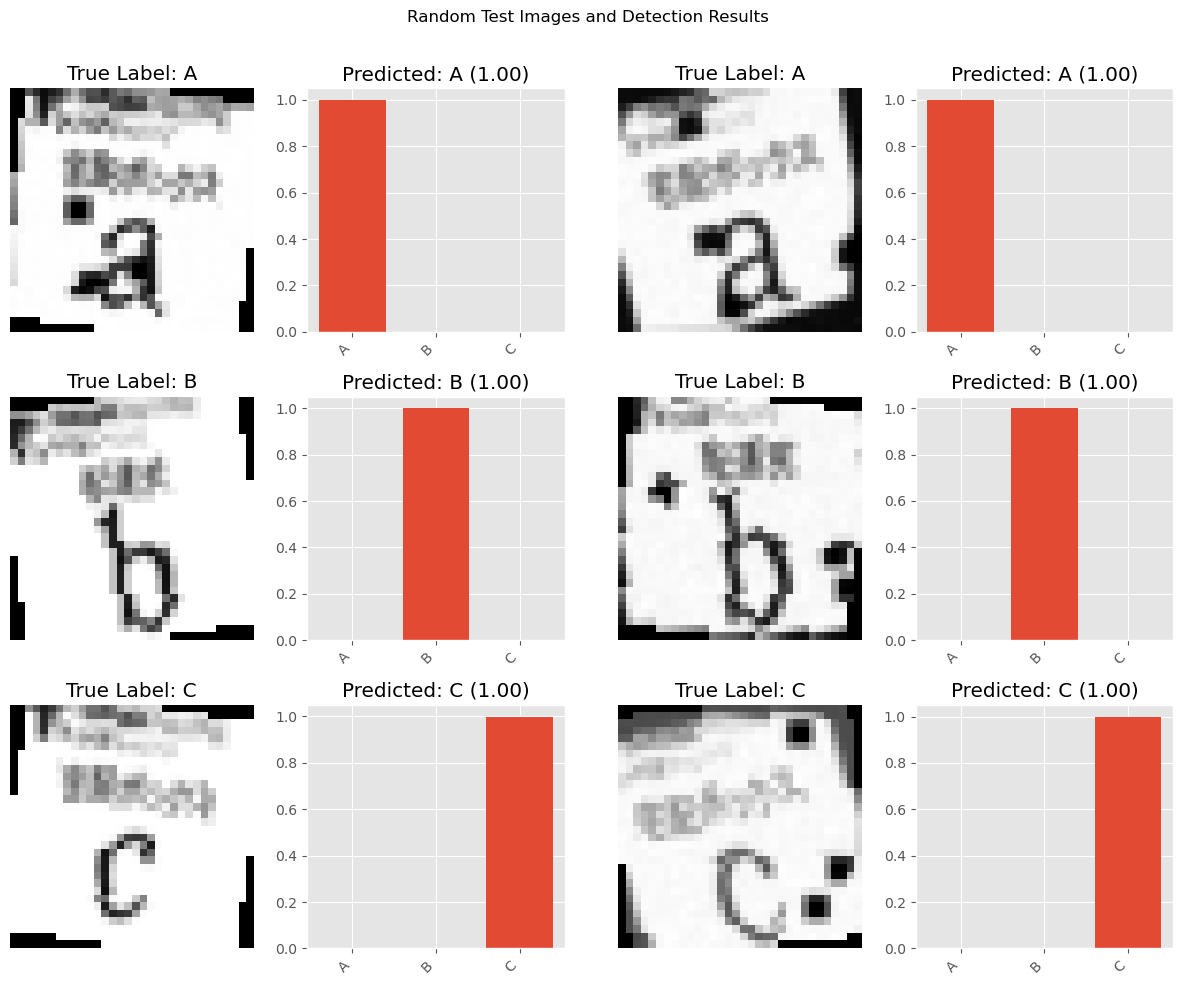

In [8]:
# Display 2 random test images from each class and their detection results
class_names = test_dataset.classes
fig, axes = plt.subplots(3, 4, figsize=(12, 10))
fig.suptitle('Random Test Images and Detection Results')

for i, class_name in enumerate(class_names):
    class_indices = [idx for idx in range(len(test_dataset)) if test_dataset[idx][1] == i]
    selected_indices = random.sample(class_indices, 2)
    
    for j, idx in enumerate(selected_indices):
        input_image, true_label = test_dataset[idx]
        input_image = input_image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(input_image)
            _, predicted = torch.max(output, 1)
            confidence = torch.softmax(output, dim=1)[0][predicted.item()].item()
        
        axes[i, j * 2].imshow(input_image.squeeze().cpu().numpy(), cmap='gray')
        axes[i, j * 2].axis('off')
        axes[i, j * 2].set_title(f'True Label: {class_name}')
        
        axes[i, j * 2 + 1].bar(class_names, torch.softmax(output, dim=1).squeeze().cpu().numpy())
        axes[i, j * 2 + 1].set_title(f'Predicted: {class_names[predicted.item()]} ({confidence:.2f})')
        axes[i, j * 2 + 1].set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## Save Model

In [9]:
torch.save(model, './weights/lenet.pt')
torch.save(model.state_dict(), './weights/lenet.pth')

---